#Imports 

In [ ]:
import tensorflow as tf
import common_functions as cf
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import os 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import sklearn 

In [ ]:
list(range(10,1-1))

[]

# Getting data with pandas

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-07 15:58:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-06-07 15:58:25 (10.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



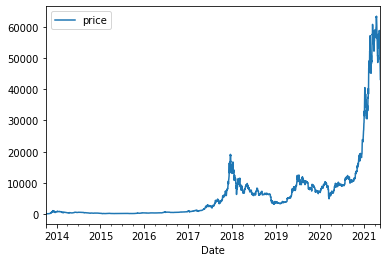

In [ ]:
csv_df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                     parse_dates = ["Date"],
                     index_col = ["Date"])
bitcoin_prices_df = pd.DataFrame(csv_df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)": "price"})
bitcoin_prices_df.plot()

# Getting Data with python

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-06-07 12:30:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-06-07 12:30:43 (7.71 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [ ]:
timesteps = []
btc_price = []

with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) #skip first line which contains column names and no data
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))


# Creating Training and test Data (for evaluation purposes)

In [ ]:
split_size = int(0.8 * len(bitcoin_prices_df))

train_df = bitcoin_prices_df[:split_size]
test_df = bitcoin_prices_df[split_size:]

plt.figure(figsize=(10,7))
cf.plot_time_series(test_df.index, test_df["price"], format ='-', label = "test")
cf.plot_time_series(train_df.index, train_df["price"], format ='-', label = "train")

X_train , y_train = train_df.index.to_numpy(), train_df["price"].to_numpy(), 
X_val , y_val  = test_df.index.to_numpy(), test_df["price"].to_numpy()

# Naive Model and MASE and other errors


In [ ]:
y_naive_preds = bitcoin_prices_df[:-1]["price"].to_numpy()
plt.figure(figsize=(10,7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [ ]:
def mase_time_series(y_true, y_pred):
  """
  assuming no seasonality of data
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive

def evaluate_time_series(y_true, y_pred):
  
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  mase = mase_time_series(y_true, y_pred)
  mae = keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  return {"mae": mae.numpy(), "mse":mse.numpy(), "rmse":rmse.numpy(), "mape":mape.numpy(), "mase":mase.numpy()}

naive_results = evaluate_time_series(y_val[1:] ,y_naive_preds[split_size:])

# Data into Windows and horizons wihtout tf

In [ ]:
def get_labelled_windows(x, window_size , horizon):
  """
  creates labels for windowed dataset
  [0...7] -> ([0...6],[7])
  """

  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size, horizon):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis = 0) 
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  return get_labelled_windows(windowed_array,window_size,horizon) 


# Extracting data (shapefix) from tf datasets

In [ ]:
# This function only does the windows horizon array has to be passed itself 
windows_dataset = keras.utils.timeseries_dataset_from_array(tf.cast(bitcoin_prices_df["price"].to_numpy(), dtype=tf.float32),
                                                            tf.cast(bitcoin_prices_df["price"].to_numpy()[7:], dtype=tf.float32 ),
                                                            sequence_length=7, batch_size=None)

train_ds = windows_dataset.take(split_size)
val_ds = windows_dataset.skip(len(train_ds))

In [ ]:

                                            # (this one might destory the ram)
train_windows, train_labels = tuple(zip(*train_ds))
train_windows = tf.squeeze(train_windows)
train_labels = tf.squeeze(train_labels)
train_ds = tf.data.Dataset.from_tensor_slices( (train_windows, train_labels) )

val_windows, val_labels = tuple(zip(*val_ds))
val_windows = tf.squeeze(val_windows)
val_labels = tf.squeeze(val_labels)
val_ds = tf.data.Dataset.from_tensor_slices( (val_windows, val_labels) )

train_ds  = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [ ]:
                                                  #mothod 2
train_windows = [] 
train_labels = []

for window, label in train_ds.unbatch().take(-1):  # only take first element of dataset
    train_windows.append(window)
    train_labels.append(label)

#tensorflow is chill with numpy arrays, cant handle lists or dictonaries

train_windows = np.array(train_windows)
train_labels = np.array(train_labels)

train_ds = tf.data.Dataset.from_tensor_slices( (train_windows, train_labels) )
train_ds  = train_ds.batch(128)

val_windows = [] 
val_labels = []

for window, label in val_ds.unbatch().take(-1):  # only take first element of dataset
    val_windows.append(window)
    val_labels.append(label)

#tensorflow is chill with numpy arrays, cant handle lists or dictonaries

val_windows = np.array(val_windows)
val_labels = np.array(val_labels)

val_ds = tf.data.Dataset.from_tensor_slices( (val_windows, val_labels) )
val_ds  = val_ds.batch(128)

#Model 1 Dense

In [ ]:
tf.random.set_seed(42)
model_1 = keras.Sequential([
                            layers.Dense(128, activation = "relu"),
                            layers.Dense(1, activation = "linear")
])

model_1.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=.001), metrics = ["mae","mse"])

model_1_history = model_1.fit(train_ds, epochs = 150, validation_data = val_ds)


In [ ]:
val_pred = model_1.predict(val_ds)
model_1_results = evaluate_time_series(tf.squeeze(val_labels), tf.squeeze(val_pred))
pd.DataFrame(model_1_history.history).plot()
plt.figure(figsize=(10,7))
cf.plot_time_series(X_val[-len(val_labels):], val_labels, format="-", start=450, label="val_data")
cf.plot_time_series(X_val[-len(val_labels):], tf.squeeze(val_pred), format="-", start=450, label="predictions")

# Model 2 window_size=30

In [ ]:
# This function only does the windows horizon array has to be passed itself 

windows_dataset = keras.utils.timeseries_dataset_from_array(tf.cast(bitcoin_prices_df["price"].to_numpy(), dtype=tf.float32),
                                                            tf.cast(bitcoin_prices_df["price"].to_numpy()[30:], dtype=tf.float32 ),
                                                            sequence_length=30, batch_size=None)

train_ds = windows_dataset.take(split_size)
val_ds = windows_dataset.skip(len(train_ds))


                                            # (this one might destory the ram)
train_windows, train_labels = tuple(zip(*train_ds))
train_windows = tf.squeeze(train_windows)
train_labels = tf.squeeze(train_labels)
train_ds = tf.data.Dataset.from_tensor_slices( (train_windows, train_labels) )

val_windows, val_labels = tuple(zip(*val_ds))
val_windows = tf.squeeze(val_windows)
val_labels = tf.squeeze(val_labels)
val_ds = tf.data.Dataset.from_tensor_slices( (val_windows, val_labels) )

train_ds  = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [ ]:
tf.random.set_seed(42)
model_2 = keras.Sequential([
                            layers.Dense(128, activation = "relu"),
                            layers.Dense(HORIZON, activation = "linear")
])

model_2.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=.001), metrics = ["mae","mse"])

model_2_history = model_2.fit(train_ds, epochs = 150, validation_data = val_ds)

In [ ]:
val_pred = model_2.predict(val_ds)
model_2_results = evaluate_time_series(tf.squeeze(val_labels), tf.squeeze(val_pred))
pd.DataFrame(model_2_history.history).plot()
plt.figure(figsize=(10,7))
hf.plot_time_series(X_val[-len(val_labels):], val_labels, format="-", start=450, label="val_data")
hf.plot_time_series(X_val[-len(val_labels):], tf.squeeze(val_pred), format="-", start=450, label="predictions")
model_2_results

# Model 3 W=30 H=7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30 
windows , labels = make_windows(bitcoin_prices_df["price"].to_numpy(), window_size=30, horizon=7)
train_windows = tf.cast(windows[:split_size], dtype=tf.float32)
train_labels = tf.cast(labels[:split_size], dtype=tf.float32)
val_windows= tf.cast(windows[split_size:], dtype=tf.float32)
val_labels = tf.cast(labels[split_size:], dtype=tf.float32)
tf.random.set_seed(42)
model_3 = keras.Sequential([
                            layers.Dense(128, activation = "relu"),
                            layers.Dense(7, activation = "linear")
])
model_3.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=.001), metrics = ["mae","mse"])

model_3_history = model_3.fit(train_windows, train_labels, epochs = 150,
                              validation_data = (val_windows,val_labels), batch_size = 128,
                              callbacks=[cf.create_model_checkpoint("model_3", onlyWeights=True)])

model_3.load_weights("/content/model_experiments/model_3")

cf.plot_loss_curves(model_3_history, plot_accuracy=False)
model_3_results= cf.evaluate_time_series(val_labels, model_3.predict(val_windows))

cf.plot_time_series(X_val[-len(val_labels):], tf.reduce_mean(val_labels, axis=1), format="-", label="actual")
cf.plot_time_series(X_val[-len(val_labels):], tf.reduce_mean(model_3.predict(val_windows), axis=1), format="-",  label="pred")

# Model 4 Conv1D W=7 H=1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
windows ,labels = make_windows(bitcoin_prices_df["price"].to_numpy(), 7, 1)

train_labels  = tf.cast(labels[:split_size], dtype=tf.float32) 
val_labels    = tf.cast(labels[split_size:], dtype=tf.float32) 
train_windows = tf.cast(windows[:split_size], dtype=tf.float32)
val_windows   = tf.cast(windows[split_size:], dtype=tf.float32)

model_4 = keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, padding='causal', activation="relu"),
    layers.Dense(2, activation="linear")
])

model_4.compile(loss="mae", optimizer="Adam", metrics=["mae", "mse"])

model_4_history = model_4.fit(train_windows, train_labels, epochs = 150,
                              validation_data = (val_windows,val_labels), batch_size = 128,
                              callbacks=[cf.create_model_checkpoint("model_4", onlyWeights=True)],
                              verbose = 1)

model_4.load_weights("/content/model_experiments/model_4")

cf.plot_loss_curves(model_4_history, plot_accuracy=False)
model_4.evaluate(val_windows, val_labels)
model_4_results= cf.evaluate_time_series(val_labels, model_4.predict(val_windows))
model_4.summary()

#Model 5 RNN W=7 H=1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
windows ,labels = make_windows(bitcoin_prices_df["price"].to_numpy(), 7, 1)

train_labels  = tf.cast(labels[:split_size], dtype=tf.float32) 
val_labels    = tf.cast(labels[split_size:], dtype=tf.float32) 
train_windows = tf.cast(windows[:split_size], dtype=tf.float32)
val_windows   = tf.cast(windows[split_size:], dtype=tf.float32)

tf.random.set_seed(42)

inputs = layers.Input(shape = (7))
x = layers.Lambda(lambda x : tf.expand_dims(x, axis=1)) (inputs)
x = layers.LSTM(128, activation="relu") (x)
outputs = layers.Dense(HORIZON)(x)

model_5 = keras.Model(inputs, outputs)

model_5.compile(loss="mae", optimizer = "Adam")

model_5_history = model_5.fit(train_windows, train_labels, epochs = 150,
                              validation_data = (val_windows,val_labels), batch_size = 128,
                              callbacks=[cf.create_model_checkpoint("model_5", onlyWeights=True)],
                              verbose = 1)
model_5.load_weights("model_experiments/model_5")
model_5.evaluate(val_windows,val_labels)
model_5_results = cf.evaluate_time_series(val_labels, model_5.predict(val_windows))

# Preparing Multivariate data

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices_df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices_df.index[0]).days

multivariate_df = bitcoin_prices_df.copy()
multivariate_df["block_reward"] = None
multivariate_df.iloc[:block_reward_2_days, -1] =  block_reward_2
multivariate_df.iloc[block_reward_2_days:block_reward_3_days , -1] =  block_reward_3
multivariate_df.iloc[block_reward_3_days:, -1] =  block_reward_4

pd.DataFrame(sklearn.preprocessing.minmax_scale(multivariate_df[["price", "block_reward"]]),
                                                                       columns=multivariate_df.columns,
                                                                       index=multivariate_df.index).plot()

for i in range(WINDOW_SIZE):
  multivariate_df[f"price{i+1}"] = multivariate_df["price"].shift(periods = i+1)

multivariate_df = multivariate_df.dropna()
y = multivariate_df["price"].to_numpy()
X = multivariate_df.drop("price", axis = 1).astype(np.float32)

X_train, X_val = X[:split_size], X[split_size:]
y_train, y_val = y[:split_size], y[split_size:]

# Model 6 Dense multivariate W=7 H=1

In [ ]:
tf.random.set_seed(42)
model_6 = keras.Sequential([
                            layers.Dense(128, activation = "relu"),
                            layers.Dense(64, activation = "relu"),
                            layers.Dense(1, activation = "linear")
])

model_6.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=.001))

model_6_history = model_6.fit(X_train, y_train, epochs = 150, validation_data = (X_val, y_val), 
                              callbacks = [cf.create_model_checkpoint("model_6")], batch_size=128)

model_6.load_weights("model_experiments/model_6")

model_6_results = cf.evaluate_time_series(y_val, tf.squeeze(model_6.predict(X_val)))
cf.plot_loss_curves(model_6_history, plot_accuracy=False)
cf.plot_time_series(bitcoin_prices_df.index[-len(y_val):], y_val, format = '-', label = "actual", start=450)
cf.plot_time_series(bitcoin_prices_df.index[-len(y_val):], model_6.predict(X_val), format = '-', label = "predicted", start=450)

Epoch 1/150
18/18 [==============================] - 1s 11ms/step - loss: 2006.2863 - val_loss: 1980.5645
Epoch 2/150
18/18 [==============================] - 0s 5ms/step - loss: 366.0823 - val_loss: 1873.8966
Epoch 3/150
18/18 [==============================] - 0s 5ms/step - loss: 232.2570 - val_loss: 1449.2363
Epoch 4/150
18/18 [==============================] - 0s 5ms/step - loss: 201.2239 - val_loss: 1074.7090
Epoch 5/150
18/18 [==============================] - 0s 5ms/step - loss: 190.8322 - val_loss: 1035.7725
Epoch 6/150
18/18 [==============================] - 0s 4ms/step - loss: 179.2048 - val_loss: 997.9075
Epoch 7/150
18/18 [==============================] - 0s 5ms/step - loss: 171.9150 - val_loss: 967.7928
Epoch 8/150
18/18 [==============================] - 0s 4ms/step - loss: 161.5332 - val_loss: 884.0356
Epoch 9/150
18/18 [==============================] - 0s 4ms/step - loss: 152.0124 - val_loss: 884.7833
Epoch 10/150
18/18 [==============================] - 0s 5ms/step 

ValueError: ignored

ValueError: ignored

# Creating N-BEATS block layers

In [ ]:
class NBeatsBlock(layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = layers.Dense(theta_size, activation="linear", name="theta_layer")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]
    return backcast, forecast

# Preparing data pipelines

In [ ]:
univariate_df = multivariate_df.drop("block_reward", axis=1)
y = univariate_df["price"].astype(np.float32)
X = univariate_df.drop("price", axis=1).astype(np.float32)
X_train, y_train, X_val, y_val = X[:split_size], y[:split_size], X[split_size:], y[split_size:]

train_features_ds = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_ds = tf.data.Dataset.from_tensor_slices(y_train)

val_features_ds = tf.data.Dataset.from_tensor_slices(X_val)
val_labels_ds = tf.data.Dataset.from_tensor_slices(y_val)

train_ds = tf.data.Dataset.zip((train_features_ds, train_labels_ds))
val_ds = tf.data.Dataset.zip((val_features_ds,val_labels_ds))

train_ds=train_ds.batch(1024).prefetch(tf.data.AUTOTUNE)
val_ds=val_ds.batch(1024).prefetch(tf.data.AUTOTUNE)

# Model 7 B-BEATS W=7 H+1

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1
# hyper paremters 

N_EPOCHS = 5000
N_NUERONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
Nbeats_layer = NBeatsBlock(input_size = INPUT_SIZE, theta_size = THETA_SIZE, horizon = HORIZON,
                           n_neurons = N_NUERONS, n_layers = N_LAYERS, name="inital_stack_layer") 
tf.random.set_seed(42)

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

backcast_1 , forecast_1 = Nbeats_layer(stack_input)

residuals = layers.Subtract()([stack_input,backcast_1])
global_forecast = forecast_1

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(INPUT_SIZE, THETA_SIZE, HORIZON, N_NUERONS, N_LAYERS, name=f"Nbeats_block{i+1}") (residuals)
  residuals = layers.Subtract()([residuals, backcast])
  global_forecast = layers.Add()([global_forecast, block_forecast])

model_7 = keras.Model(inputs = stack_input, outputs = global_forecast)
keras.utils.plot_model(model_7, show_shapes = True)

model_7.compile(loss="mae", optimizer = "Adam")

model_7_history = model_7.fit(train_ds, epochs = N_EPOCHS, validation_data=val_ds, 
            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                         keras.callbacks.ReduceLROnPlateau(pateince = 50, factor=0.1, monitor = "val_loss", verbose = 1)])

In [ ]:
model_7_results = cf.evaluate_time_series(y_val, model_7.predict(val_ds))
model_7_results
cf.plot_loss_curves(model_7_history, plot_accuracy = False)
cf.plot_time_series(bitcoin_prices_df.index[-len(y_val):], y_val, format = '-', label = "actual", start=450)
cf.plot_time_series(bitcoin_prices_df.index[-len(y_val):], model_7.predict(val_ds), format = '-', label = "predicted", start=450)

# Model 8 ensemble

In [ ]:
def get_ensemble_model(horizon, train_ds, val_ds, num_iter, num_epochs, loss_fun):
  
  ensemble_models=[]

  for i in range(num_iter):
    for loss_function in loss_fun:
      print(f"Model{i} with loss {loss_function} for {num_epochs} epochs")
      model = tf.keras.Sequential([
              layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
              layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
              layers.Dense(horizon)
      ])

      model.compile(loss=loss_function,
                    optimizer = "Adam",
                    metrics = ["mae", "mse"])
      model.fit(train_ds, epochs = num_epochs, validation_data = val_ds, verbose = 0,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                          keras.callbacks.ReduceLROnPlateau(pateince = 100, factor=0.1, monitor = "val_loss", verbose = 0)])
      
      ensemble_models.append(model)
  
  return ensemble_models

def make_ensemble_preds(ensemble_models, val_ds):
  ensemble_preds = []
  for model in ensemble_models:
    ensemble_preds.append(model.predict(val_ds))
  return ensemble_preds

def get_lower_upper(preds):
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  mean = tf.reduce_mean(preds, axis=0)
  lower = mean - interval
  upper = mean + interval
  return lower, upper


In [ ]:
ensemble_models = get_ensemble_model(1, train_ds, val_ds, 5, 1000, loss_fun=["mae", "mse", "mape"])

ensemble_preds = tf.squeeze(np.array(make_ensemble_preds(ensemble_models, val_ds)))
lower ,upper = get_lower_upper(ensemble_preds)
ensemble_preds = np.median(ensemble_preds, axis=0)

ensemble_model_results = cf.evaluate_time_series(y_val, ensemble_preds)

cf.plot_time_series( bitcoin_prices_df.index[-len(y_val):], lower ,format = "-", start=450)
cf.plot_time_series( bitcoin_prices_df.index[-len(y_val):], upper , format = "-", start=450)

plt.fill_between(X_val.index[-450:], lower[-450:], upper[-450:], label="pridcition_Interval")

#Model 9 into the future

In [ ]:
y = multivariate_df["price"].to_numpy()
X = multivariate_df.drop("price", axis=1).astype(np.float32)

X_ds = tf.data.Dataset.from_tensor_slices(tf.cast(X, dtype=tf.float32)) 
y_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, dtype=tf.float32))

all_ds = tf.data.Dataset.zip((X_ds, y_ds))
all_ds = all_ds.batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.random.set_seed(42)
model_9 = keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(128, activation="relu"),
          layers.Dense(1, activation="linear")                            
])

model_9.compile( loss="mae", optimizer = "Adam")

model_9_history = model_9.fit(all_ds, epochs=100, verbose =0)

cf.plot_loss_curves(model_9_history, plot_accuracy=False, only_training_data = True)

In [ ]:
import datetime
def predict_into_future(model, days, X):
  horizon = tf.squeeze(model_9.predict(X))[-1].numpy()
  predictions = [horizon]
  for _ in range(days-1):

    br = X["block_reward"][-1]
    p1 = X["price2"][-1]
    p2 = X["price3"][-1]
    p3 = X["price4"][-1]
    p4 = X["price5"][-1]
    p5 = X["price6"][-1]
    p6 = X["price7"][-1] 
    p7 = horizon              
  
    row = pd.DataFrame(
      {'Date': (X.index[-1]), 'block_reward':br, 'price1': p1, 'price2': p2 , 
       'price2': p3, 'price3': p4, 'price4': p4, 'price5': p5, 'price6': p6, 'price7': p7},
       index = ["Date"])
    X = X.append(row)

    horizon = tf.squeeze(model.predict( np.array( [[[br,p1,p2,p3,p4,p5,p6,p7]]] ) )).numpy()
    predictions.append(horizon)
  
  return np.array(predictions), X

In [ ]:
future_predictions, X = predict_into_future(model_9, 100, X)
cf.plot_time_series(np.arange(len(y)+len(future_predictions)), np.concatenate((y,future_predictions),axis=0), format="-")
X.head()

,block_reward,price1,price2,price3,price4,price5,price6,price7,Date
2013-10-08 00:00:00,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991,NaT
2013-10-09 00:00:00,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,NaT
2013-10-10 00:00:00,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,NaT
2013-10-11 00:00:00,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,NaT
2013-10-12 00:00:00,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,NaT
